In [54]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Create the Value class

In [55]:
class Value:

    def __init__(self, data, _children=(), _operator=None, label=None):
        self.data = data
        self.grad = 0.0  # initialize gradient to 0
        self._backward = lambda: None  # function to call to backpropagate
        self._previous = set(_children)
        self._operator = _operator
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data + other.data, _children=(self, other), _operator="+")

        def _backward():
            self.grad += output.grad
            other.grad += output.grad

        output._backward = _backward
        return output
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, _children=(self, other), _operator="*")

        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad

        output._backward = _backward
        return output

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only integer and float exponents are supported"
        output = Value(self.data**other, (self,), _operator=f"**{other}")

        def _backward():
            self.grad += other * self.data**(other - 1) * output.grad

        output._backward = _backward
        return output

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        output = Value(t, _children=(self,), _operator="tanh")

        def _backward():
            self.grad += (1 - t**2) * output.grad

        output._backward = _backward
        return output

    def exp(self):
        x = self.data
        output = Value(math.exp(x), (self,), _operator="exp")

        def _backward():
            self.grad += math.exp(x) * output.grad
        
        output._backward = _backward

        return output

    def backward(self):
        topo = []
        visited = set()


        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._previous:
                    build_topo(child)
                topo.append(v)


        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [56]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

## Visualize the Value Graph

In [57]:
from graphviz import Digraph


def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            
            for child in v._previous:
                edges.add((child, v))
                build(child)

    build(root)

    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)

    for node in nodes:
        uid = str(id(node))

        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape='record')

        if node._operator:
            # if this value is a result of some operation, craete an op node for it
            dot.node(name=uid + node._operator, label=node._operator)

            # and connect this node to it
            dot.edge(uid + node._operator, uid)

    for child, parent in edges:
        # connect the child to the parent
        dot.edge(str(id(child)), str(id(parent)) + parent._operator)

    return dot


## Backpropagation with a Neuron

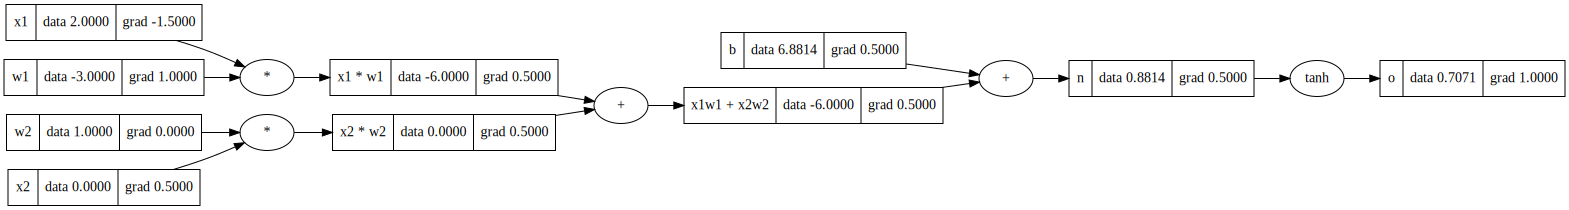

In [58]:
# inputs of neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# compute the neuron
# n = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1
x1w1.label = "x1 * w1"

x2w2 = x2 * w2
x2w2.label = "x2 * w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"

# activation function (tanh)
o = n.tanh()
o.label = "o"

# backprop
o.backward()

draw_dot(o)

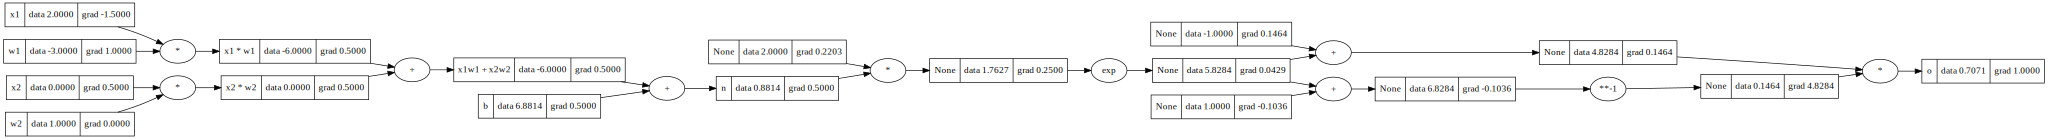

In [59]:
# inputs of neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# compute the neuron
# n = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1
x1w1.label = "x1 * w1"

x2w2 = x2 * w2
x2w2.label = "x2 * w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b
n.label = "n"

# activation function (tanh)
# o = n.tanh()
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = "o"

# backprop
o.backward()

draw_dot(o)

In [60]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print('-' * 20)
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
--------------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [61]:
class Neuron:
    def __init__(self, nin): # nin = number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # weights
        self.b = Value(random.uniform(-1, 1)) # bias

    def __call__(self, x): 
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # activation
        out = act.tanh() # output
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout): # nin = number of inputs, nout = number of outputs
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP: # Multi-Layer Perceptron
    def __init__(self, nin, nouts): # nin = number of inputs, nouts = number of outputs
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [62]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.8520615706354954)

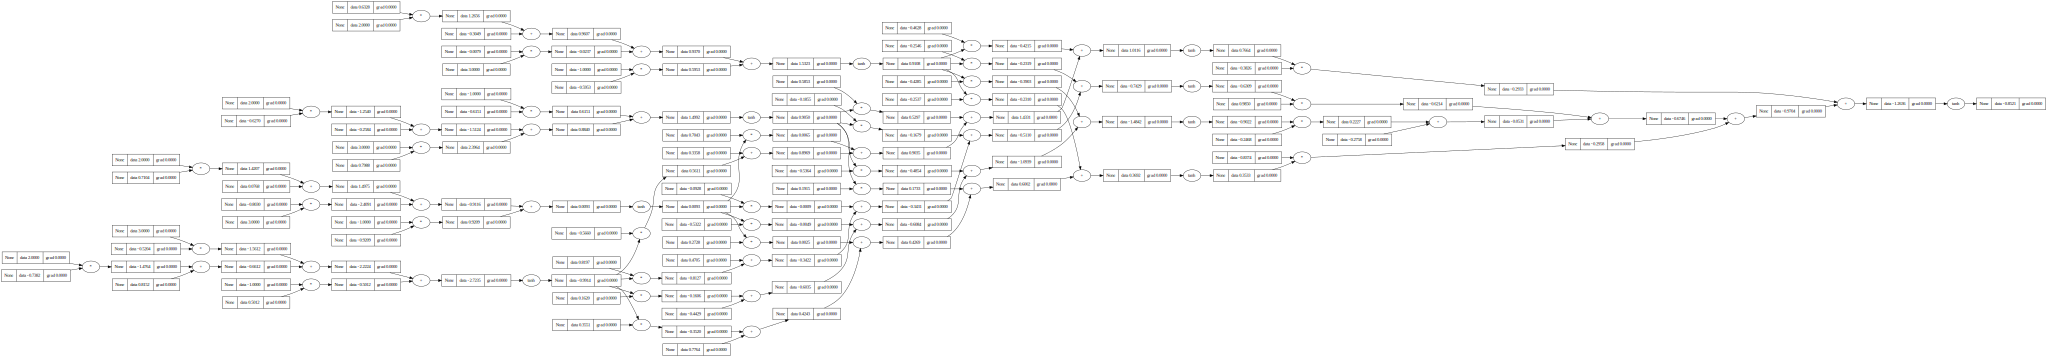

In [63]:
draw_dot(n(x))

In [64]:
# example dataset
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # labels

In [65]:
ypreds = [n(x) for x in xs] # predictions
ypreds

[Value(data=-0.8520615706354954),
 Value(data=-0.5971932709626433),
 Value(data=0.02775427604121266),
 Value(data=-0.8533680759192402)]

In [66]:
# mean squared error loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypreds))
loss

Value(data=8.083637399140176)

In [67]:
loss.backward()

In [68]:
n.layers[0].neurons[0].w[0].grad

0.7593986624057204

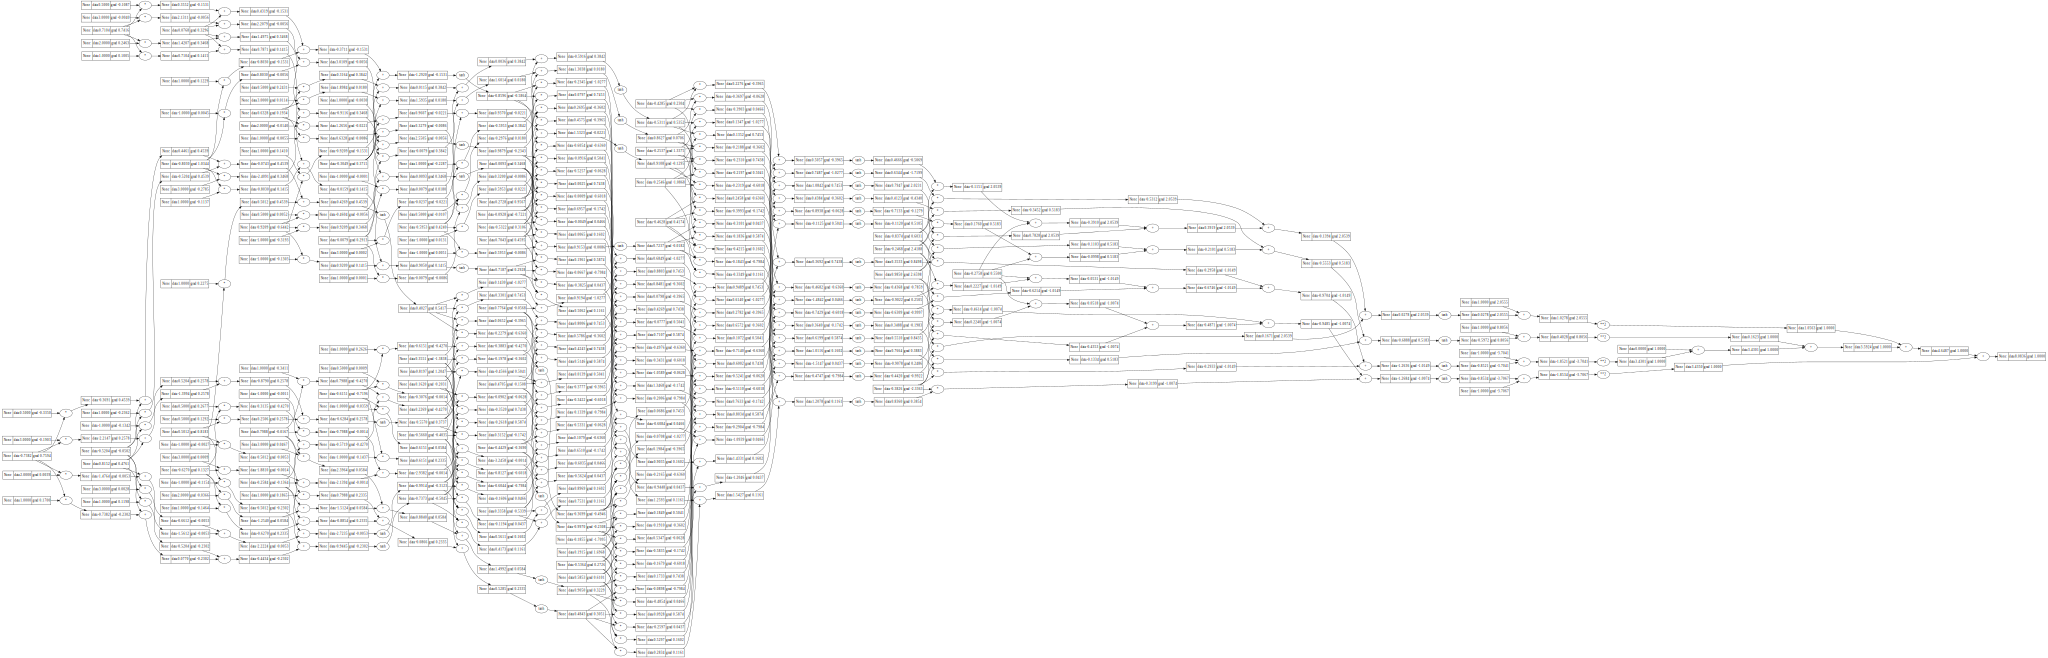

In [69]:
draw_dot(loss)

In [70]:
for k in range(100):
    # forward pass
    ypreds = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypreds))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
        
    loss.backward()

    # update parameters (gradient descent)
    for p in n.parameters():
        p.data -= 0.1 * p.grad

    print(k, loss.data)


0 8.083637399140176
1 3.5843409205378514
2 2.6592389346239784
3 0.34398250276016445
4 0.17240901901802835
5 0.11849347372974084
6 0.08971264640759116
7 0.07157871071157171
8 0.059216378740717765
9 0.05030819851281421
10 0.04361536106341206
11 0.03842039205583114
12 0.034281407486601176
13 0.030912557982729738
14 0.028121346317445464
15 0.025773721958407214
16 0.02377364914381785
17 0.02205063312578323
18 0.02055182591187958
19 0.019236872265740425
20 0.018074451993337168
21 0.017039903967316937
22 0.016113558359721857
23 0.015279543513559275
24 0.014524917656000119
25 0.013839027172924595
26 0.013213025626579281
27 0.012639508608880246
28 0.012112233265299801
29 0.011625900522366815
30 0.011175984312386112
31 0.010758596416410407
32 0.010370378580598447
33 0.010008415716640458
34 0.00967016554718482
35 0.009353401184920708
36 0.009056163963095196
37 0.008776724450939515
38 0.008513550048970244
39 0.008265277908088172
40 0.008030692182447981
41 0.007808704830497939
42 0.0075983393368249